Column names: ['Bankname', 'Tablename', 'Exposureclass', 'OriginalexposureOBS', 'OriginalexposureOffBS', 'AverageCCF', 'EAD', 'AveragePD', 'Obligornumber', 'AverageLGD', 'Averagematurity', 'RWA', 'RWA%', 'EL', 'Provisions']
Remaining NaNs after filling: 0


C:\Users\fiona\AppData\Local\Temp\ipykernel_79904\563574730.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


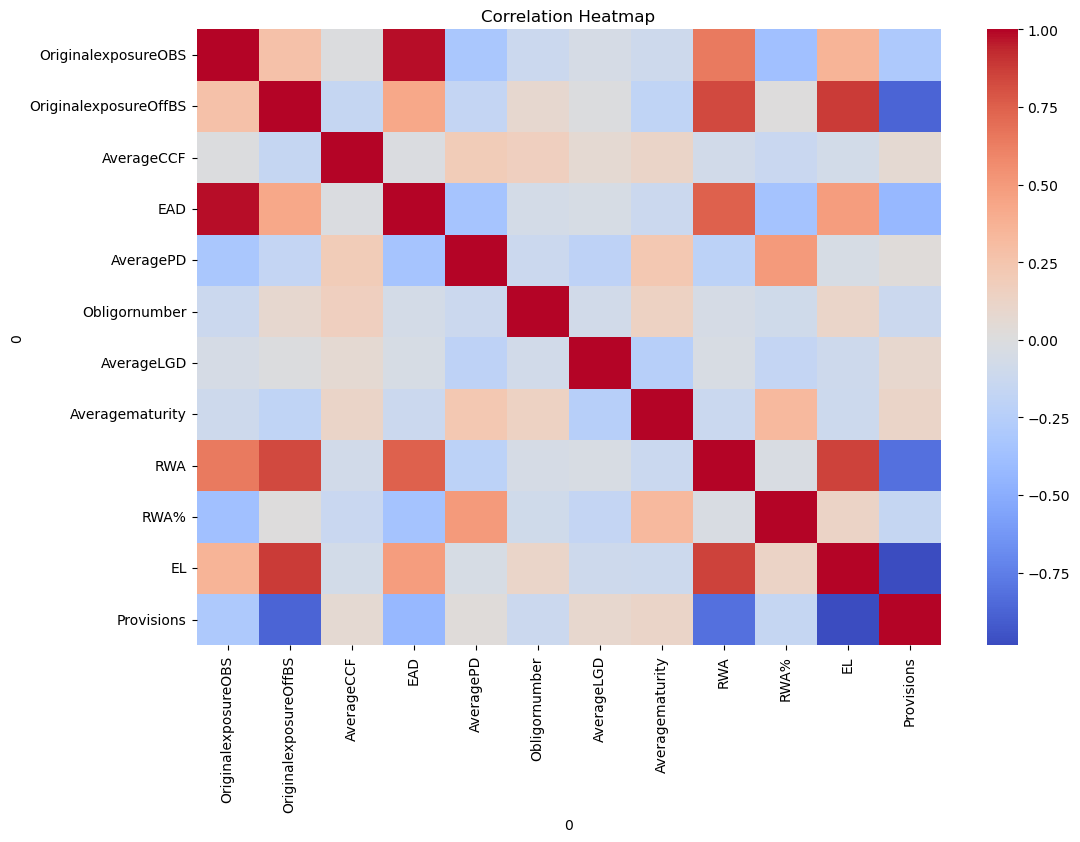

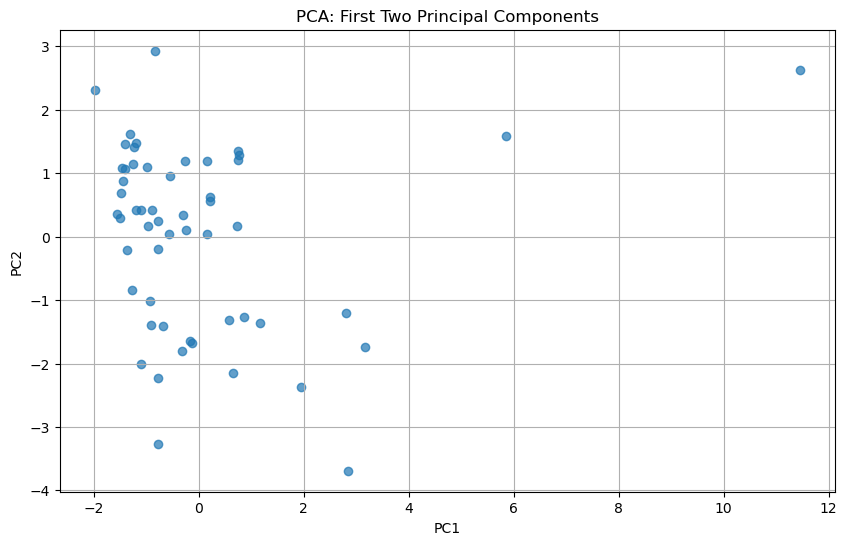

[0.37278011 0.17975941]
                            PC1       PC2
OriginalexposureOBS    0.325550 -0.319519
OriginalexposureOffBS  0.406606  0.184171
AverageCCF            -0.055610 -0.022505
EAD                    0.375386 -0.270291
AveragePD             -0.142275  0.439748
Obligornumber          0.013315  0.071566
AverageLGD            -0.020496 -0.246821
Averagematurity       -0.103733  0.267840
RWA                    0.453384  0.056598
RWA%                  -0.069588  0.553071
EL                     0.420776  0.263313
Provisions            -0.406977 -0.284327


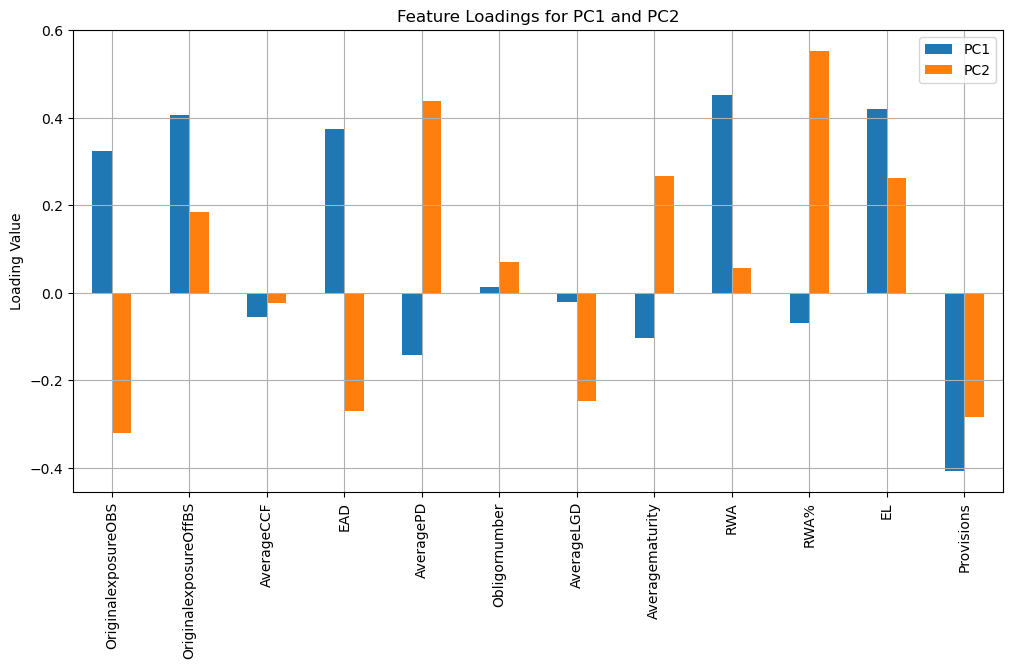

Cleaned and scaled data saved to CR6_cleaned_scaled.csv


In [27]:
# Jupyter Notebook: 01_data_exploration.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Load data with headers
file_path = 'Combined standardised Pillar 3 data.xlsx'
df_raw = pd.read_excel(file_path, sheet_name='Sheet1', header=None)

#Set column headers using first row and drop that row
df_raw.columns = df_raw.iloc[0].astype(str)
df = df_raw.drop(index=0).reset_index(drop=True)

#Check column names
print("Column names:", df.columns.tolist())

#Identify text columns by name
text_cols = [col for col in df.columns if col.lower() in ['bankname', 'tablename', 'exposureclass']]

#Convert all other columns to numeric values
numeric_cols = [col for col in df.columns if col not in text_cols]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Fill missing values in numeric columns with the median
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

#Confirm no missing values remain
print("Remaining NaNs after filling:", df[numeric_cols].isnull().sum().sum())

#Scale numeric columns which applies z-score normalisation to each numeric column.
#As there are very different scales used in the data (millions, percentages, years, individual obligor number)
#these need to be scaled so that the larger features do not dominate the model. This ensures that there is equal
#contribution of each feature.
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#Print a correlation matrix
#This is useful to gain insight into any initial pairwise correlations between elements within
#the pillar 3 data.
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

#Confirm no NaNs and plot PCA
if df_scaled[numeric_cols].isnull().sum().sum() == 0:
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_scaled[numeric_cols])
    df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

    plt.figure(figsize=(10, 6))
    plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
    plt.title('PCA: First Two Principal Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()
    print(pca.explained_variance_ratio_)
else:
    print("PCA not performed due to presence of NaNs after scaling.")

#This shows the loadings of the components that will contribute to PC1 and PC2. Items with
#higher loadings will contribute more to that component. PC2 will include features that are statistically independent of PC1.
pca_loadings = pd.DataFrame(pca.components_.T, columns = ['PC1','PC2'],index=numeric_cols)
print(pca_loadings)
pca_loadings.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Loadings for PC1 and PC2')
plt.ylabel('Loading Value')
plt.grid(True)
plt.show()

#Save data
cleaned_data_path = 'CR6_cleaned_scaled.csv'
df_scaled.to_csv(cleaned_data_path, index=False)
print(f"Cleaned and scaled data saved to {cleaned_data_path}")
